# L3 - Math3-ML - MACHINE LEARNING
## Objectifs du TP4 - clustering avec sklearn


Actuellement, l'apprentissage statistique (machine learning) en python se fait essentiellement avec le package très complet nommé `scikit-learn`. Ainsi durant les TP 4, 5 et 6 nous verrons comment l'utiliser dans les différents cas statistiques que nous pouvons rencontrer. 

![](apprentissage1.png)

Durant le TP4 nous nous concentrerons sur les cas de clustering. 

En reprenant les notations standards, soit $X \in \mathbb{R}^{n \times p}$ une matrice exprimant $p$ variables pour $n$ individus. Soit $Y \in \mathbb{R}^n$ une variable réponse que nous essayons à prédire. 

Dans le cas du clustering, nous n'avons que la matrice $X$. Donc il n'est pas question de prédire dans le cadre du clustering mais plutôt de trouver des groupes d'individus homogènes. 

Ainsi la plupart des méthodes de clustering vont minimiser un critère afin de trouver ces groupes homogènes. 

Ce TP a pour but d'explorer plusieurs méthodes et en comparer leurs résultats. 


# Notations mathématiques

Soit la matrice de données $X$, le but est de trouver une partition $C$ des $n$ individus de l'étude. 

Soit $X_{i.} \in \mathbb{R}^p$ le vecteur de mesure de l'idividus $i$. Soit la variable de mesure $X_{.j} \in \mathbb{R}^n$.

Soit $C$ la partition tel que $C \in \{1, ..., K\}^n$ avec $K$ le nombre de groupe obtenue. 
Soit $C_k \subset C$ l'ensemble des individus du groupe $k$. 

Soit $\mu_k \in \mathbb{R}^p$ le barycentre des individus contenus dans le groupe $k$ tels que $\forall k \in \{1, ..., K\}, \mu_k = \frac{1}{n_k} \sum_{i \in C_k} X_{i.}$ avec $n_k = |C_k|$ 

In [1]:
import pandas as pd 
import numpy as np 
import sklearn
from sklearn import decomposition

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

La documentation `sklearn` est très bien faite. Il y a des pages traitant d'une problématique comme le [clustering](https://scikit-learn.org/stable/modules/clustering.html) et des pages de documentation de fonctions comme celle pour les [`keamns`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

# Préparation du jeu de données 

Pour commencer ce TP nous allons utiliser les données Iris de Fisher. Comme nous n'avons rien à prédire nous ne prendrons pas en compte la variable espèce. 

Récuperer le fichier csv disponible sur moodle et importer le. On mettra dans une variable `truth` la variable espèces et garderons les autres variables dans une matrice $X$. 

Afin de visualiser facilement ces données, nous utiliserons une méthode de réduction de dimension "Analyse en composante principale" dite ACP (ou PCA en anglais). Nous ne nous attarderons pas dans ce TP à comprendre comment elle fonctionne mais pourrons être amener à l'utiliser afin de réduire des dimensions de jeux de données pour l'exécution des méthodes de machine learning comme pour de la visualisation. 

In [3]:
iris = pd.read_csv("iris.csv", header = None)
iris.columns = ["sepal.length", "sepale.width", "petal.length", "petal.width", "species"]
iris

,sepal.length,sepale.width,petal.length,petal.width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
%qtconsole

In [12]:
truth = iris[["species"]]
truth

,species
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [13]:
X = iris.drop(["species"], axis = 1)
X

,sepal.length,sepale.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [14]:
pca = decomposition.PCA(n_components = 2)
pca_point = pca.fit_transform(X)

In [15]:
%qtconsole

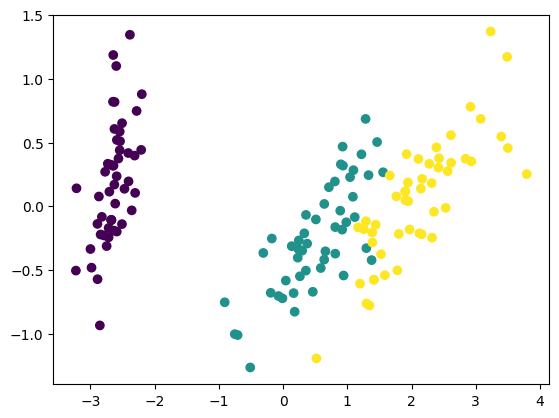

,PC1,PC2,truth
0,-2.684207,0.326607,Iris-setosa
1,-2.715391,-0.169557,Iris-setosa
2,-2.889820,-0.137346,Iris-setosa
3,-2.746437,-0.311124,Iris-setosa
4,-2.728593,0.333925,Iris-setosa
...,...,...,...
145,1.944017,0.187415,Iris-virginica
146,1.525664,-0.375021,Iris-virginica
147,1.764046,0.078519,Iris-virginica
148,1.901629,0.115877,Iris-virginica


In [16]:
pca_df = pd.DataFrame(pca_point)
pca_df.columns = ["PC1", "PC2"]
pca_df[["truth"]] = truth

classes = np.unique(pca_df["truth"])
str2int = dict((k, v) for (v, k) in enumerate(classes))
colors =  np.vectorize(str2int.get)(pca_df["truth"])


plt.scatter(pca_df["PC1"], pca_df["PC2"], c=colors)
plt.show()
pca_df

# K-means

La méthode des $k$-means est souvent considérée comme une baseline dans les problèmes de clustering par sa rapidité et sa facilité d'interprétation. 

L'algorithme des $k$-means a pour but de choisir des centroids $\mu_k$ qui minimise l'inertie intra-classe $\sum_{i = 1}^n \underset{k = \{1, ..., K\}}{\min} || x_i - \mu_k ||_2^2$. 

L'algorithme se fait de manière suivante : 

- Initialisation : on choisit aléatoirement $K$ points dans le jeu de données $\mu_1, ... \mu_K$
- Itérativement : 
    - On affecte à chaque individus le groupe contenant le $\mu_k$ le plus proche 
    - on recalcule les $\mu_k$ tels qu'ils soient les centroids de chaque groupe. 
- L'algorithme s'arrete lorsque la partition n'est plus modifié. 

Un des hyperparamètres important de l'algorithme est le nombre de cluster que nous souhaitons. Dans certains cas l'application permet de connaitre le nombre de clusters que nous souhaitons mais dans d'autre cas il n'y a pas d'apriori dessus. Ainsi il est parfois interessant de récupérer plusieurs partitions dépendant du nombre de groupe désiré. 

1) Récupérer les partitions (clustering) des données en fonction du nombre de clusters désirés. Nous regarderons les clustering pour $k$ allant de $1$ à $10$. 
Nous stockerons ces clustering dans une matrice nommé `clust_kmeans` avec en ligne les individus et en colonnes le  nombre de clusters désirés. 

2) Afficher le nuage de point sur les deux premières compsantes principales en coloriants avec 

In [23]:
from sklearn import cluster

In [16]:
kmeans = cluster.KMeans(n_clusters = 2)
kmeans.fit(X)
kmeans.labels_
# X.describe()

K = range(2,11)
clust_kmeans = pd.DataFrame(index = range(150), columns = K)

for k in K: 
    kmeans = cluster.KMeans(n_clusters = k)
    kmeans.fit(X)
    clust_kmeans[k] = kmeans.labels_
#     sns.scatterplot(pca_df["PC1"], pca_df["PC2"], hue = kmeans.labels_)
clust_kmeans

,2,3,4,5,6,7,8,9,10
0,1,1,0,1,1,5,4,2,4
1,1,1,0,1,5,1,0,6,0
2,1,1,0,1,5,1,0,6,0
3,1,1,0,1,5,1,0,6,0
4,1,1,0,1,1,5,4,2,4
...,...,...,...,...,...,...,...,...,...
145,0,2,3,2,4,0,1,1,2
146,0,0,1,4,0,6,6,7,9
147,0,2,1,2,4,0,1,1,2
148,0,2,3,2,4,0,1,1,2


<Axes: xlabel='PC1', ylabel='PC2'>

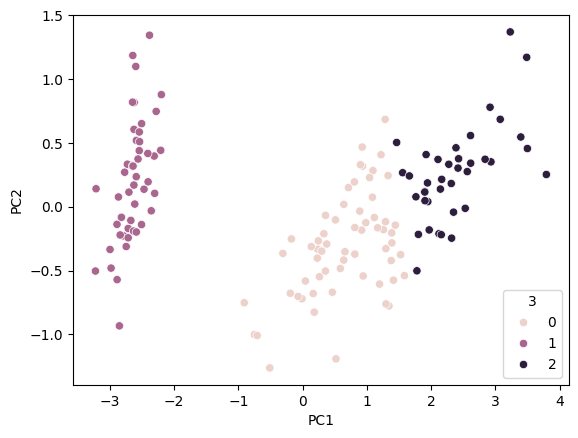

In [20]:
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue = clust_kmeans[3])

<Axes: xlabel='PC1', ylabel='PC2'>

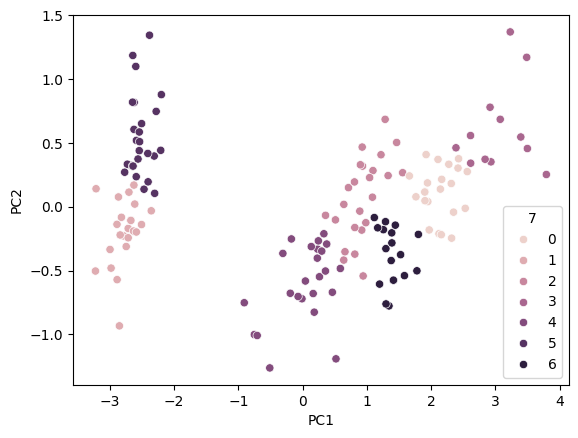

In [21]:
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue = clust_kmeans[7])

# Clustering Hierarchique Ascendant

Le clustering Ascendant hierarchique permet de créer une suite de partition emboité. 

Le but de ces algorithmes est de fusionner petit à petit les individus. On commence par mettre chaque individu dans sa propre classe (singleton) puis on fusionne les classes qui minimisent une mesure d'agrégation et on recommence itérativement jusqu'à ce qu'il n'y ait plus qu'une seule classe.

Dans la littérature plusieurs méthodes de d'aggrégation existent mais la plus complète et performance est la méthode de Ward. Cette méthode à l'avantage de minimiser l'intertie intraclasse et de maximiser l'intertie interclasse. C'est à dire de créer des groupes homogènes (ils sont très proche les uns des autres) et éloigné les uns des autres. 

Dans ce cas, il n'y a pas a priori un nombre de clusters à préciser. Il peut être choisi a posteriori de différentes manières. Dans notre cas, nous jugerons le nombre de clusters à la vue d'un dendrograme où nous choisirons le nombre de classe en fonction d'un des plus grands sauts entre les fusions. 

1) Similairement à la question précédentes, faire le clustering pour différentes méthodes. On sélectionnera le nombre de classe par vu sur le dendrograme. 

In [38]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

clust_HAC = pd.DataFrame(index = range(150), columns = range(1,5)) #
clust_HAC.columns = ['ward', 'complete', 'average', 'single']

In [41]:
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "ward")
model = model.fit(X)

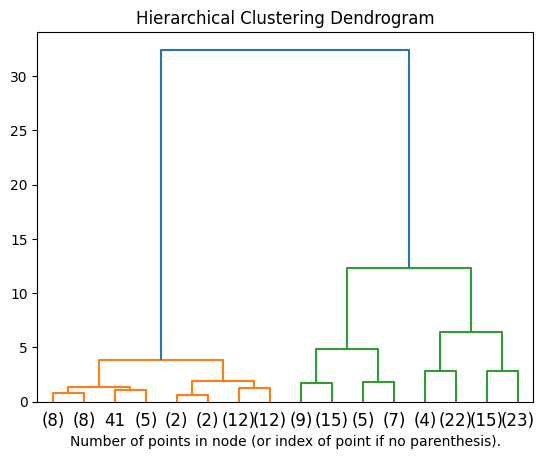

In [45]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
model = cluster.AgglomerativeClustering( n_clusters=3, linkage = "ward")
model = model.fit(X)
clust_HAC['ward'] = model.labels_

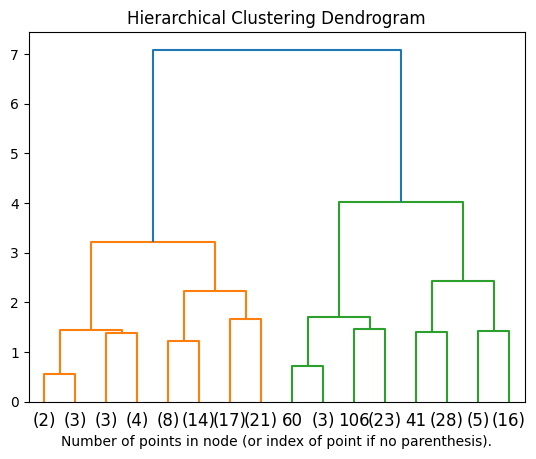

In [24]:
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "complete")

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



model = cluster.AgglomerativeClustering( n_clusters=2, linkage = "complete")
model = model.fit(X)
clust_HAC['complete'] = model.labels_

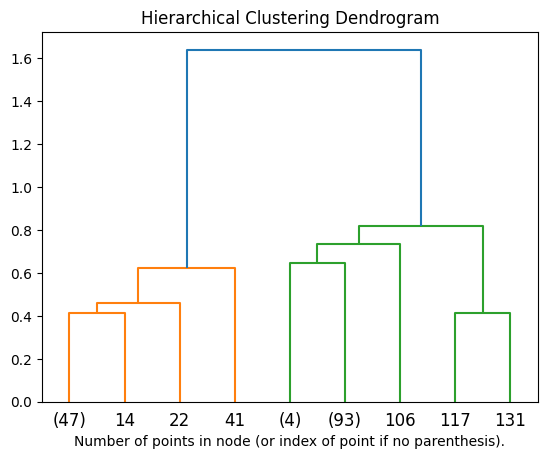

In [25]:
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "single")

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



model = cluster.AgglomerativeClustering( n_clusters=2, linkage = "single")
model = model.fit(X)
clust_HAC['single'] = model.labels_

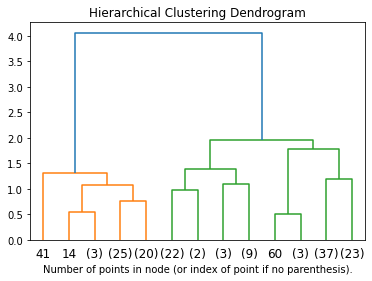

In [191]:
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "average")

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



model = cluster.AgglomerativeClustering( n_clusters=2, linkage = "average")
model = model.fit(X)
clust_HAC['average'] = model.labels_

/home/nenjalbe/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

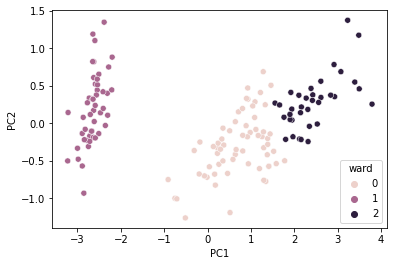

In [192]:
sns.scatterplot(pca_df["PC1"], pca_df["PC2"], hue = clust_HAC["ward"])

/home/nenjalbe/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

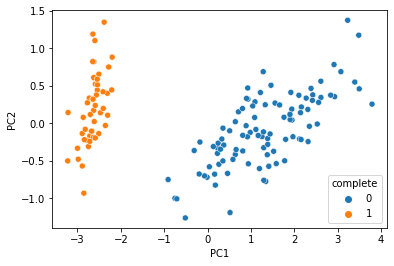

In [193]:
sns.scatterplot(pca_df["PC1"], pca_df["PC2"], hue = clust_HAC["complete"])

/home/nenjalbe/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

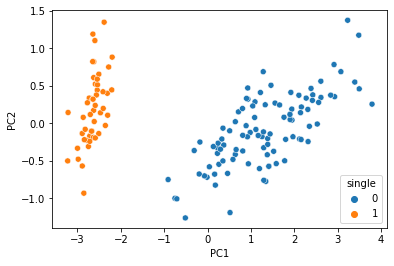

In [194]:
sns.scatterplot(pca_df["PC1"], pca_df["PC2"], hue = clust_HAC["single"])

/home/nenjalbe/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

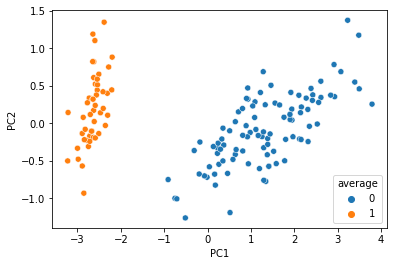

In [195]:
sns.scatterplot(pca_df["PC1"], pca_df["PC2"], hue = clust_HAC["average"])

# DBSCAN

DBSCAN est un algorithme de clustering basé sur la spacialité. En effet son critère d'optimisation cherche à trouver des zones à forte densité séparées par des zones à faible densité. Les zones obtenues représentent les clusters désirés. Le paramètre qui va influer sur le nombre de classe est epsilon qui représente la boule de recherche de zone à densité. 

In [37]:
eps = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 2]
clust_DBSCAN = pd.DataFrame(index = range(150), columns = range(1,len(eps)+1))
clust_DBSCAN.columns = eps

for e in eps: 
    clust_DBSCAN[e] = cluster.DBSCAN(eps = e).fit(X).labels_
#     sns.scatterplot(pca_df["PC1"], pca_df["PC2"], hue = kmeans.labels_)
clust_DBSCAN

,0.1,0.3,0.5,0.7,0.9,1.0,2.0
0,-1,0,0,0,0,0,0
1,-1,0,0,0,0,0,0
2,-1,0,0,0,0,0,0
3,-1,0,0,0,0,0,0
4,-1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
145,-1,-1,1,1,1,1,0
146,-1,-1,1,1,1,1,0
147,-1,-1,1,1,1,1,0
148,-1,-1,1,1,1,1,0


array([[<Axes: title={'center': '0.1'}>, <Axes: title={'center': '0.3'}>,
        <Axes: title={'center': '0.5'}>],
       [<Axes: title={'center': '0.7'}>, <Axes: title={'center': '0.9'}>,
        <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: >, <Axes: >]],
      dtype=object)

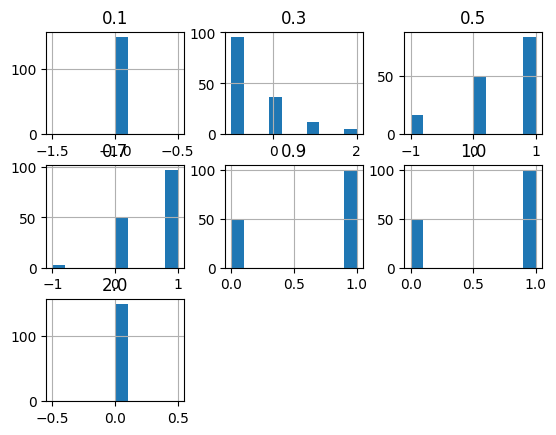

In [38]:
import pandas
pandas.DataFrame(clust_DBSCAN).hist()

<Axes: xlabel='PC1', ylabel='PC2'>

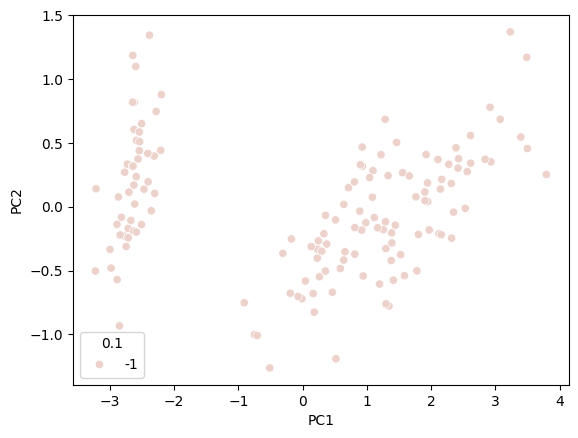

In [40]:
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue = clust_DBSCAN[0.1])

<Axes: xlabel='PC1', ylabel='PC2'>

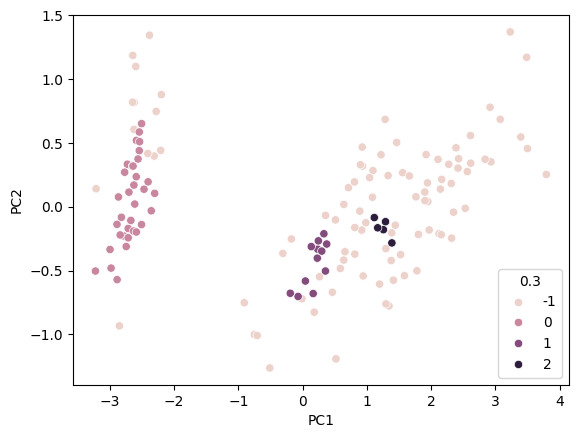

In [41]:
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue = clust_DBSCAN[0.3])

<Axes: xlabel='PC1', ylabel='PC2'>

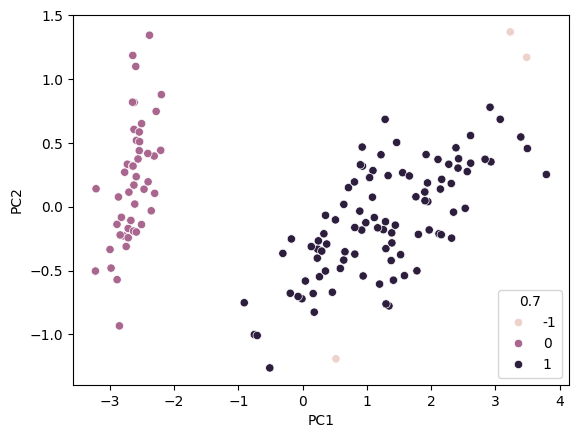

In [42]:
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue = clust_DBSCAN[0.7])

# Selection de modèle 

Nous avons vu durant ces exemples que le choix des hyperparamètres ne permettait pas d'avoir des résultats constants dans la formation des clusters. Alors comment choisir la bonne partition ? 

Plusieurs critères existent pour pouvoir faire ces choix. 
Nous verrons ici quatre critères qui permettent de faire de la selection de modèles. 

In [205]:


# clust_kmeans.columns = ["Kmeans " + str(s) for s in clust_kmeans.columns]
# clust_HAC.columns = ["HAC " + str(s) for s in clust_HAC.columns]
# clust_DBSCAN.columns = ["DBSCAN " + str(s) for s in clust_DBSCAN.columns]
clust = pd.concat([clust_kmeans, clust_HAC, clust_DBSCAN], axis = 1)
clust.columns = (["Kmeans " + str(s) for s in clust_kmeans.columns]) + (["HAC " + str(s) for s in clust_HAC.columns]) + (["DBSCAN " + str(s) for s in clust_DBSCAN.columns])

## Table de contingence

La table de contingence est un outil statistique simple qui permet de voir rapidement si les individus sont classé dans la même classe entre deux partitions. Deux partitions similaires donneront une matrice diagonale. 

In [44]:
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(clust_kmeans[2], truth)

array([[ 0, 47, 50],
       [50,  3,  0]])

1) Regarder pour plusieurs clustering si leurs partitions concordonnent. Est ce que vous trouvez certains schéma ? 

## Silhouette

Le coefficient de la Silhouette est très utile si la vérité n'est pas connu. Il va mesurer l'homogénéité des groupes. Est ce que les groupes sont assez éloignés des uns des autres ? Est ce que les groupes ne sont pas trop éparpillés ? 

In [47]:
from sklearn import metrics

metrics.silhouette_score(X, clust_HAC['ward'], metric = "euclidean")

0.5540972908150553

Pour chaque méthode de clustering, comparer le coefficient de la silhouette afin de sélectionner le modèle avec le meilleur résultat. Enfin sélectionner la meilleure méthode pour nos données. 

In [48]:
clust_kmeans.columns

RangeIndex(start=2, stop=11, step=1)

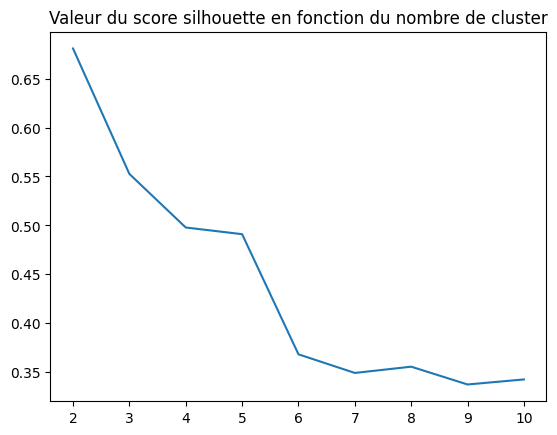

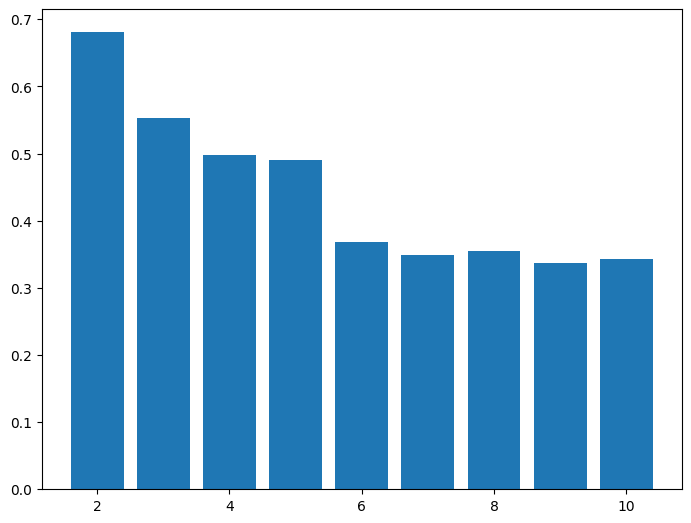

Partition pourlaquelle le kmeans donne un meilleur résultat selon la méthode de la silhouette :  2


In [49]:
silhouette_kmeans = {}
sil_kmeans_plot = []
for k in clust_kmeans.columns: 
    silhouette_kmeans[k] = metrics.silhouette_score(X, clust_kmeans[k], metric = "euclidean")
    sil_kmeans_plot.append(metrics.silhouette_score(X, clust_kmeans[k], metric = "euclidean"))
    
plt.plot(clust_kmeans.columns, sil_kmeans_plot)
plt.title("Valeur du score silhouette en fonction du nombre de cluster")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust_kmeans.columns,sil_kmeans_plot)
plt.show()

print("Partition pourlaquelle le kmeans donne un meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette_kmeans, key=silhouette_kmeans.get))

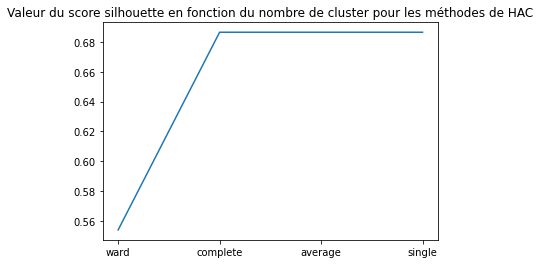

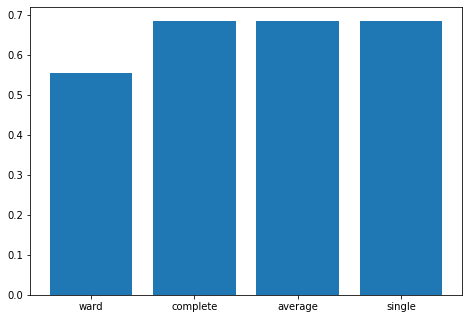

Partition pourlaquelle le HAC donne un meilleur résultat selon la méthode de la silhouette :  complete


In [210]:
silhouette_HAC = {}
sil_HAC_plot = []
for k in clust_HAC.columns: 
    silhouette_HAC[k] = metrics.silhouette_score(X, clust_HAC[k], metric = "euclidean")
    sil_HAC_plot.append(metrics.silhouette_score(X, clust_HAC[k], metric = "euclidean"))
    
plt.plot(clust_HAC.columns, sil_HAC_plot)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de HAC")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust_HAC.columns,sil_HAC_plot)
plt.show()

print("Partition pourlaquelle le HAC donne un meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette_HAC, key=silhouette_HAC.get))

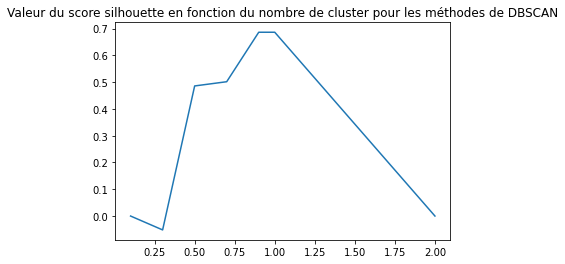

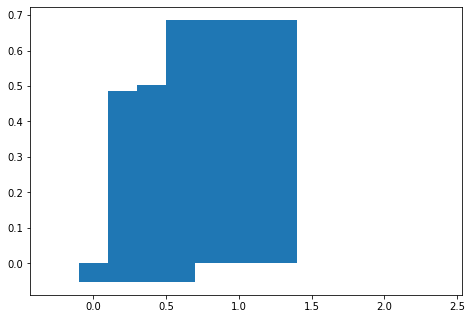

Partition pourlaquelle le DBSCAN donne un meilleur résultat selon la méthode de la silhouette :  0.9


In [211]:
silhouette_DBSCAN = {}
sil_DBSCAN_plot = []
for k in clust_DBSCAN.columns: 
    if (len(np.unique(clust_DBSCAN[k])) == 1): 
        silhouette_DBSCAN[k] = 0
        sil_DBSCAN_plot.append(0)
    else : 
        silhouette_DBSCAN[k] = metrics.silhouette_score(X, clust_DBSCAN[k], metric = "euclidean")
        sil_DBSCAN_plot.append(metrics.silhouette_score(X, clust_DBSCAN[k], metric = "euclidean"))
    
plt.plot(clust_DBSCAN.columns, sil_DBSCAN_plot)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust_DBSCAN.columns,sil_DBSCAN_plot)
plt.show()

print("Partition pourlaquelle le DBSCAN donne un meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette_DBSCAN, key=silhouette_DBSCAN.get))

In [212]:
["DBSCAN " + str(s) for s in clust_DBSCAN.columns]

['DBSCAN 0.1',
 'DBSCAN 0.3',
 'DBSCAN 0.5',
 'DBSCAN 0.7',
 'DBSCAN 0.9',
 'DBSCAN 1.0',
 'DBSCAN 2.0']

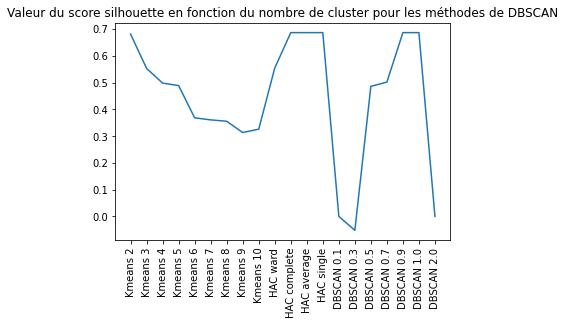

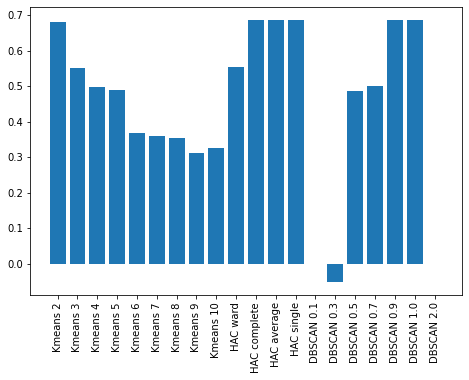

Meilleur résultat selon la méthode de la silhouette :  HAC complete


In [213]:


silhouette = {}
sil_plot = []
for k in clust.columns: 
    if (len(np.unique(clust[k])) == 1): 
        silhouette[k] = 0
        sil_plot.append(0)
    else : 
        silhouette[k] = metrics.silhouette_score(X, clust[k], metric = "euclidean")
        sil_plot.append(metrics.silhouette_score(X, clust[k], metric = "euclidean"))
    
plt.plot(clust.columns, sil_plot)
plt.xticks(rotation=90)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust.columns,sil_plot)
plt.xticks(rotation=90)
plt.show()

print("Meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette, key=silhouette.get))

## V mesure

La mesure V demande de connaitre la vérité que nous cherchons à approcher. La mesure V est fonction de deux autres mesures: 

- Homogénéité : chaque cluster ne contient que des individus du même type (au sens de la vérité)
- Completeness : tous les membres d'un même type sont affectés au même clusters. 

On voit que ces deux mesures vont dans deux sens différents mais sont très complémentaires afin d'avoir un bon clustering (et retrouver la vérité). 

La mesure V est mesuré telque : $$v = \frac{(1+\beta) \times \text{homogeneity} \times \text{completness}}{\beta (\text{homogeneity}+\text{completness})}$$

1) Trouver le clustering qui s'approche le plus de la vérité. 

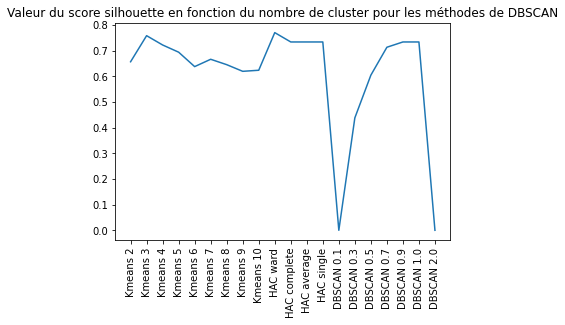

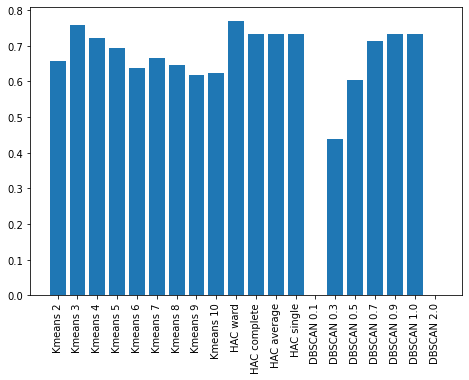

Meilleur résultat selon la méthode de la silhouette :  HAC ward


In [219]:
Vmesure = {}
Vmesure_plot = []
for k in clust.columns: 
    if (len(np.unique(clust[k])) == 1): 
        Vmesure[k] = 0
        Vmesure_plot.append(0)
    else : 
        Vmesure[k] = metrics.v_measure_score(truth["species"], clust[k])
        Vmesure_plot.append(metrics.v_measure_score(truth["species"], clust[k]))
    
plt.plot(clust.columns, Vmesure_plot)
plt.xticks(rotation=90)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust.columns,Vmesure_plot)
plt.xticks(rotation=90)
plt.show()

print("Meilleur résultat selon la méthode de la silhouette : ", 
     max(Vmesure, key=Vmesure.get))

In [218]:
truth["species"]

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: species, Length: 150, dtype: object

## Adjusted Rand Index

L'index de Rand est un score qui permet de mesurer la similitude entre deux partitions en comparant les paires de points deux à deux en mesurant si ces deux points sont classés ensemble ou non dans les deux partitions. La formule simplifié est : 
Soit a le nombre de paires d'individus regroupés dans les deux paritions et b le nombre d'individus qui ne sont regroupé ni dans la partition 1 ni dans la partition 2. Soit $\binom{n}{2}$ le nombre de paires d'individus totale possibles. 
L'indice de Rand est $$ RI = \frac{a+b}{\binom{n}{2}}$$

La formule ajustée permet de mieux comparer des partitions avec des nombres de classe différentes: 
$$Adjusted RI = \frac{RI - \mathbb{E}[RI]}{ \max RI - \mathbb{E}[RI]} $$
avec $\mathbb{E}[RI]$ l'espérance de l'indice de Rand. 

Cet indice s'interprète comme suivant : 
Plus la valeur est proche de 1 plus les partitions sont similaires. Un ARI de 1 signifie que les partitions sont strictement les mêmes. Un ARI de 0 signifie que les deux partitions sont "indépendantes" (ici à ne pas prendre comme le sens strictement mathématique de l'indépendance). 


Un avantage de cette métrique est que les labels des clusterings peuvent être strictement différents, le score sera toujours le même. Pourquoi est ce interessant ? 

Mesurer le ARI de chaque partition avec la vérité (c'est à dire les epèces d'iris) et donner la meilleures partitions. 

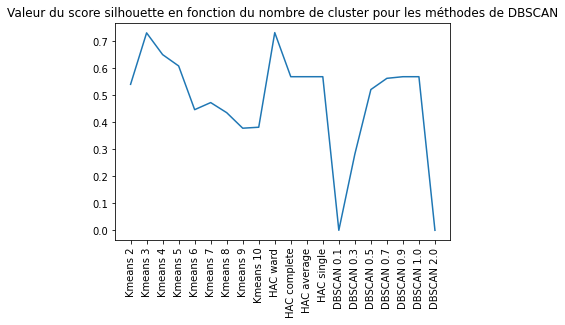

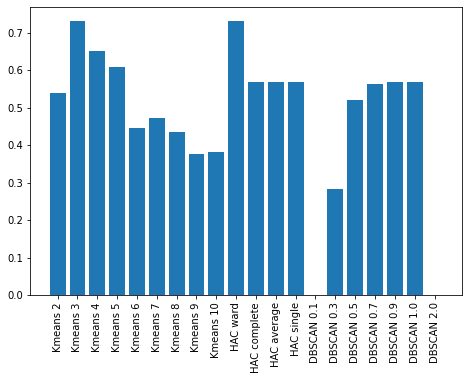

Meilleur résultat selon la méthode de la silhouette :  HAC ward


In [220]:
ARI = {}
ARI_plot = []
for k in clust.columns: 
    if (len(np.unique(clust[k])) == 1): 
        ARI[k] = 0
        ARI_plot.append(0)
    else : 
        ARI[k] = metrics.adjusted_rand_score(truth["species"], clust[k])
        ARI_plot.append(metrics.adjusted_rand_score(truth["species"], clust[k]))
    
plt.plot(clust.columns, ARI_plot)
plt.xticks(rotation=90)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust.columns,ARI_plot)
plt.xticks(rotation=90)
plt.show()

print("Meilleur résultat selon la méthode de la silhouette : ", 
     max(ARI, key=ARI.get))

## Conclusion 

Quelles sont vos conclusions ? 

Quelles distinctions peut on voir entre les clusterings ?
Est ce que les méthodes de sélections de modèles donnent comme meilleur résultat le même clustering ? 